## **Import Library yang dibutuhkan**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## **Load data rumah**

In [ ]:
# Membaca data dari file TSV
filepath = 'data_rumah.tsv'
data = pd.read_csv(filepath, sep='\t')

## **Preprocessing Data**

In [ ]:
# Preprocessing Data
# Ubah data kota menjadi numerik
categorical_columns = ['Kabupaten/Kota', 'kecamatan', 'kelurahan', 'keamanan (ada/tidak)', 'taman (ada/tidak)']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# formatting data numerik
numerical_columns = ['jumlah kamar tidur','jumlah kamar mandi','luas tanah (m2)','carport (mobil)','jarak dengan rumah sakit terdekat (km)', 'jarak dengan sekolah terdekat (km)', 'jarak dengan tol terdekat (km)']
for col in numerical_columns:
    data[col] = data[col].astype(str)
    data[col] = data[col].str.replace(',', '.')
    data[col] = pd.to_numeric(data[col], errors='coerce')
data = data.dropna()

In [ ]:
data['harga rumah'] = data['harga rumah'].astype(str)
data['harga rumah'] = data['harga rumah'].str.replace('[^0-9]', '', regex=True)
data['harga rumah'] = data['harga rumah'].astype(int)

data['jarak dengan rumah sakit terdekat (km)'] = data['jarak dengan rumah sakit terdekat (km)'].astype(float)
data['jarak dengan sekolah terdekat (km)'] = data['jarak dengan sekolah terdekat (km)'].astype(float)
data['jarak dengan tol terdekat (km)'] = data['jarak dengan tol terdekat (km)'].astype(float)
data['jumlah kamar tidur'] = data['jumlah kamar tidur'].astype(float)
data['jumlah kamar mandi'] = data['jumlah kamar mandi'].astype(float)
data['luas tanah (m2)'] = data['luas tanah (m2)'].astype(float)
data['carport (mobil)'] = data['carport (mobil)'].astype(float)
data['pasokan listrik (watt)'] = data['pasokan listrik (watt)'].astype(float)

data = data.drop(columns=['No','NRP','Nama','Link Data Rumah'])

In [ ]:
data['harga rumah log'] = np.log1p(data['harga rumah'])

# Remove outliers
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_cleaned

data = remove_outliers(data)

X = data.drop(['harga rumah', 'harga rumah log'], axis=1)
y = data['harga rumah log']

# **Pengaplikasian StandardScaler dan PCA**

In [ ]:
# Standardisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

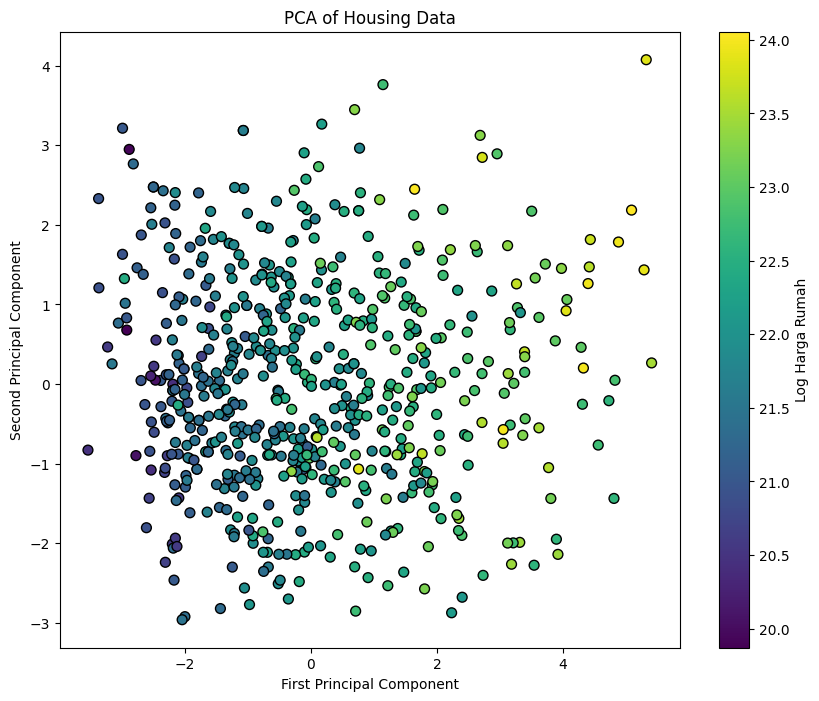

In [ ]:
# Plotting PCA
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Housing Data')
plt.colorbar(label='Log Harga Rumah')
plt.show()

# **Split data training dan test**

In [ ]:
# Membagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

## **Pembentukan model awal**

Linear Regression:
  MAE: 0.29544443252315283
  MSE: 0.1566080263857954
  R2 Score: 0.7071868114011555

Decision Tree Regression:
  MAE: 0.42068918986179255
  MSE: 0.3176069292105381
  R2 Score: 0.4061639124796457

Random Forest Regression:
  MAE: 0.29175512328142217
  MSE: 0.1483186771508474
  R2 Score: 0.7226855750144274

XGBoost Regression:
  MAE: 0.3042455095575816
  MSE: 0.16190937373041994
  R2 Score: 0.6972747752451955



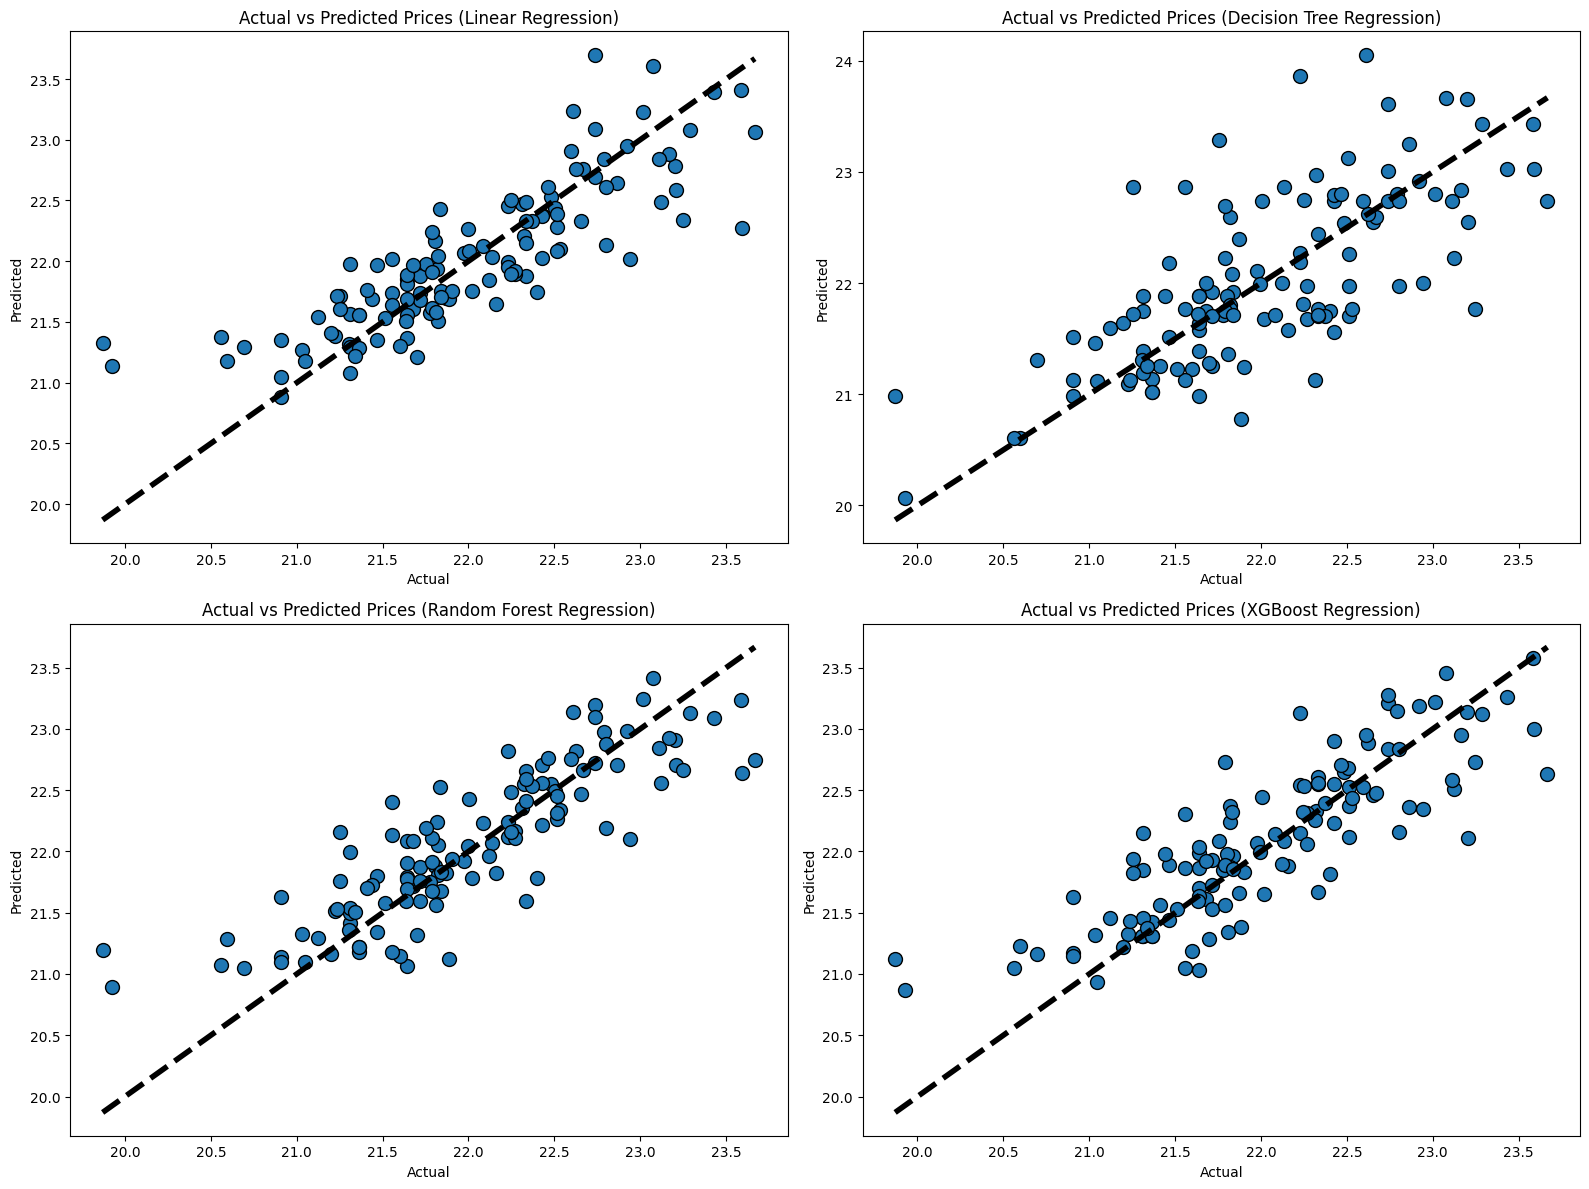

In [ ]:
# Inisialisasi model
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'XGBoost Regression': XGBRegressor()
}

# Melatih dan mengevaluasi model
evaluation_results = {}
predictions = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[model_name] = y_pred

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name}:")
    print(f"  MAE: {mae}")
    print(f"  MSE: {mse}")
    print(f"  R2 Score: {r2}\n")

# Plotting Actual vs Predicted for each model
plt.figure(figsize=(16, 12))

for i, model_name in enumerate(models.keys()):
    plt.subplot(2, 2, i + 1)
    plt.scatter(y_test, predictions[model_name], edgecolor='k', s=100)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted Prices ({model_name})')

plt.tight_layout()
plt.show()

## **Tuning best model dan best params**

Best Linear Regression:
  Best Parameters: {}
  MAE: 0.29544443252315283
  MSE: 0.1566080263857954
  R2 Score: 0.7071868114011555

Best Decision Tree Regression:
  Best Parameters: {'max_depth': None, 'min_samples_split': 10}
  MAE: 0.41758308565774294
  MSE: 0.29038232879812764
  R2 Score: 0.45706629749182526

Best Random Forest Regression:
  Best Parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
  MAE: 0.2948425822868871
  MSE: 0.14686921421185278
  R2 Score: 0.7253956651338018

Best XGBoost Regression:
  Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
  MAE: 0.2758095601119238
  MSE: 0.13174721358974137
  R2 Score: 0.7536695749859458



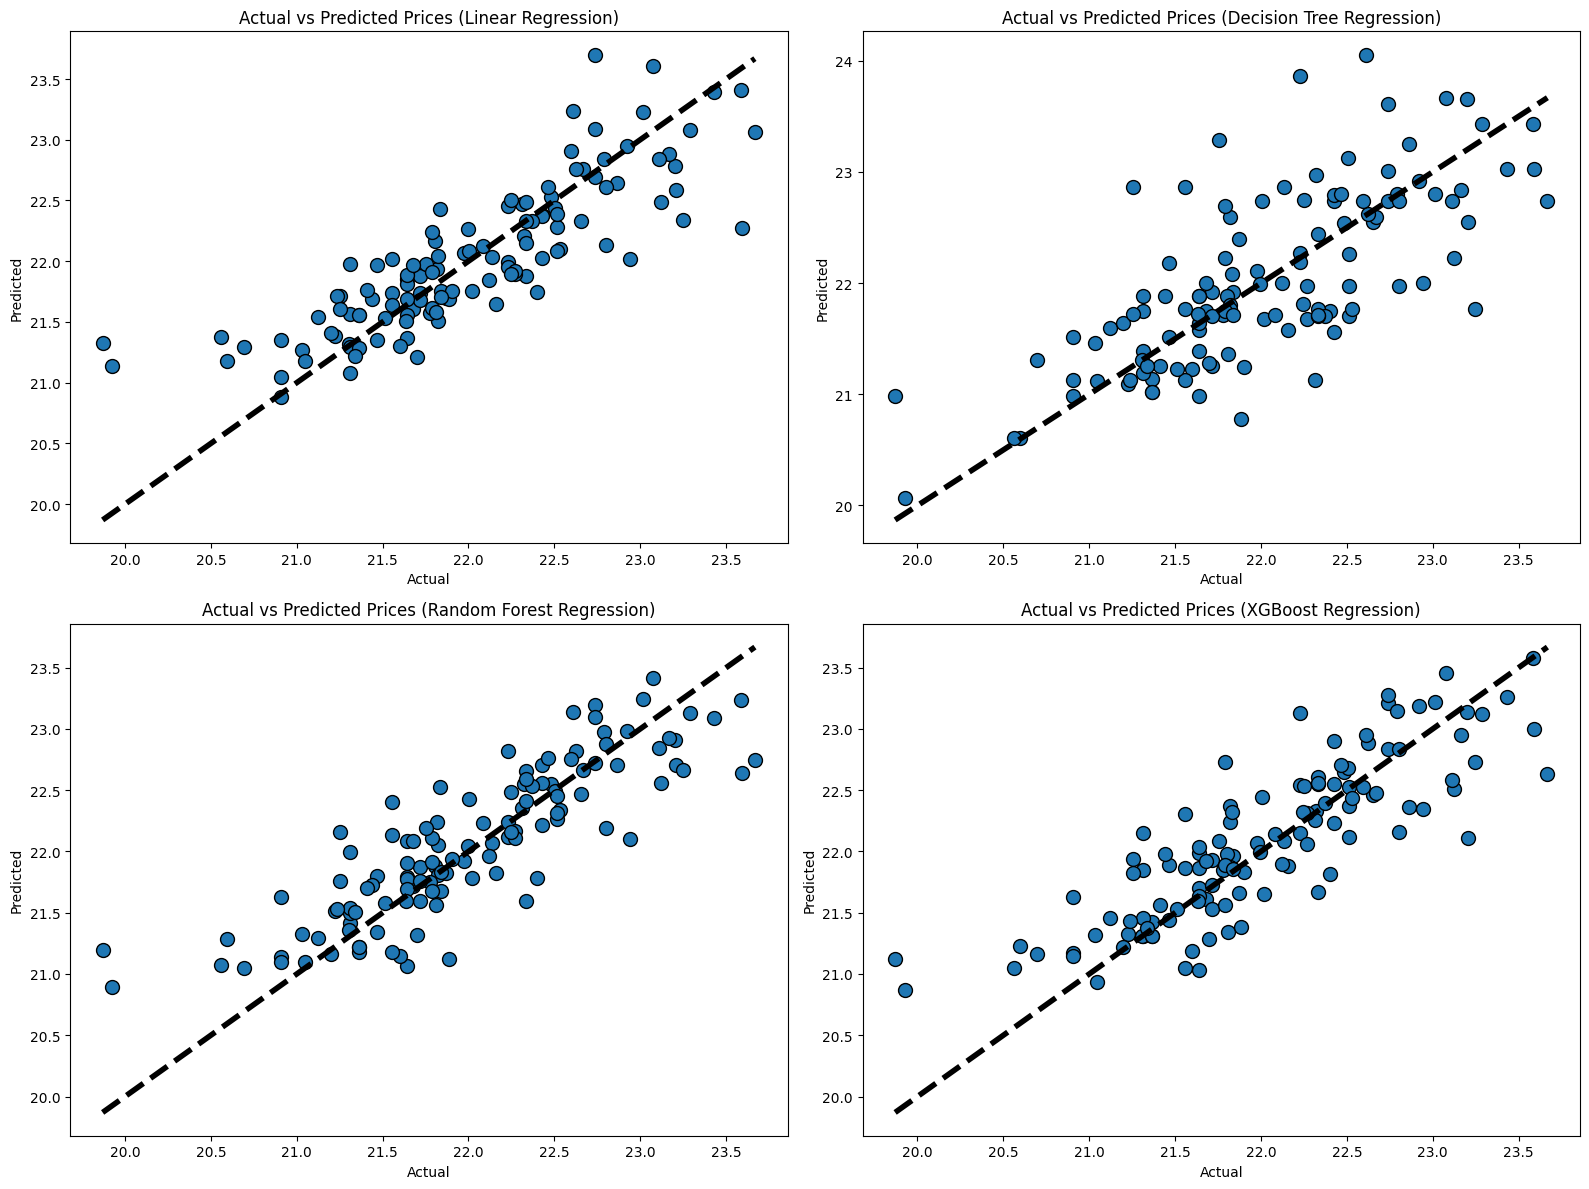

In [ ]:
# Parameter grids for each model
param_grids = {
    'Linear Regression': {},
    'Decision Tree Regression': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest Regression': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost Regression': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Tuning dan evaluasi model terbaik
for model_name in param_grids.keys():
    grid_search = GridSearchCV(estimator=models[model_name], param_grid=param_grids[model_name], cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Best {model_name}:")
    print(f"  Best Parameters: {best_params}")
    print(f"  MAE: {mae}")
    print(f"  MSE: {mse}")
    print(f"  R2 Score: {r2}\n")

# Plotting Actual vs Predicted for each model
plt.figure(figsize=(16, 12))

for i, model_name in enumerate(models.keys()):
    plt.subplot(2, 2, i + 1)
    plt.scatter(y_test, predictions[model_name], edgecolor='k', s=100)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted Prices ({model_name})')

plt.tight_layout()
plt.show()

In [ ]:
import joblib

# Save best model and components
joblib.dump(best_model, 'best_xgboost_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')

['pca.pkl']